In [1]:
import sacc
import numpy as np
import rosatX as rx
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import emcee
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

data/Jtot_Z0.30_padb.pck
data/Jtot_Z0.30_padb.pck


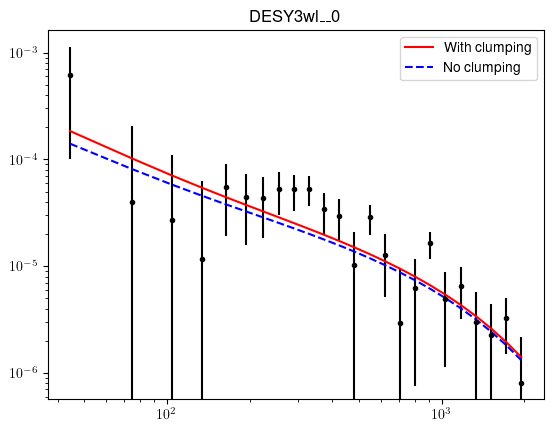

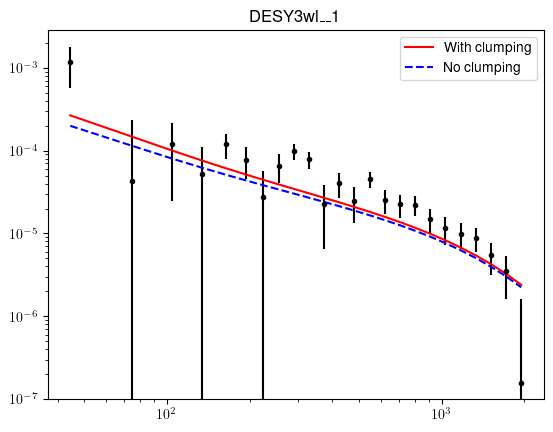

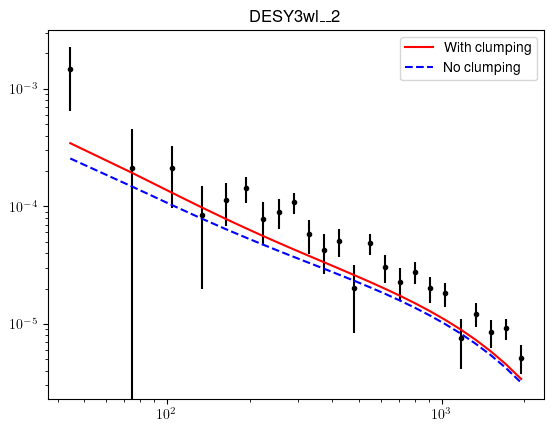

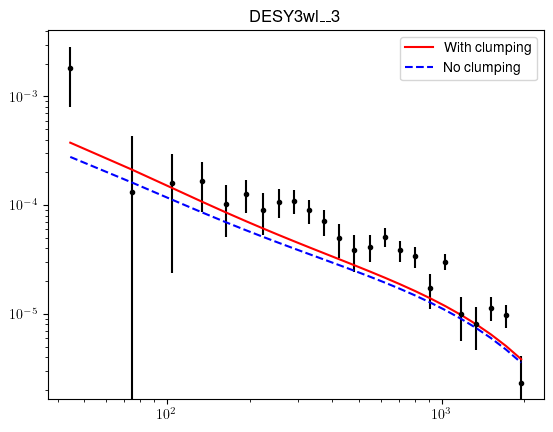

In [2]:
lc = rx.ROSATxLike(params_vary=['logTAGN'],
                   priors={'logTAGN': [7.5, 8.2]})
lnc = rx.ROSATxLike(params_vary=['logTAGN'],
                    priors={'logTAGN': [7.5, 8.2]}, with_clumping=False)
cls_c = lc.get_model(logTAGN=8.0)
cls_nc = lnc.get_model(logTAGN=8.0)

for i, d in enumerate(lc.cl_meta):
    plt.figure()
    plt.title(d['t2'])
    plt.errorbar(d['ls'], d['cld'],
                 yerr=np.sqrt(np.diag(d['cov'])),
                 fmt='k.')
    plt.plot(d['ls'], cls_c[i], '-', c='r', label='With clumping')
    plt.plot(d['ls'], cls_nc[i], '--', c='b', label='No clumping')
    plt.loglog()
    plt.legend()

data/Jtot_Z0.30_padb.pck
data/Jtot_Z0.30_padb.pck


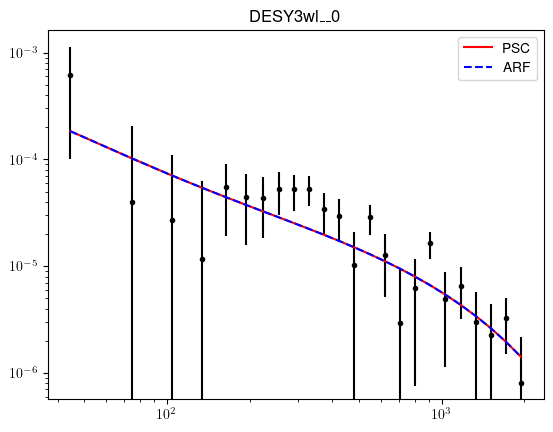

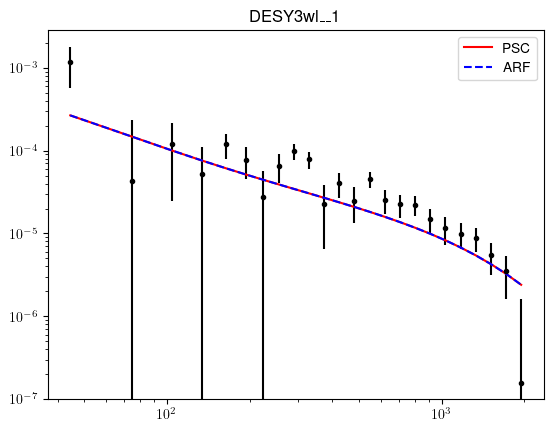

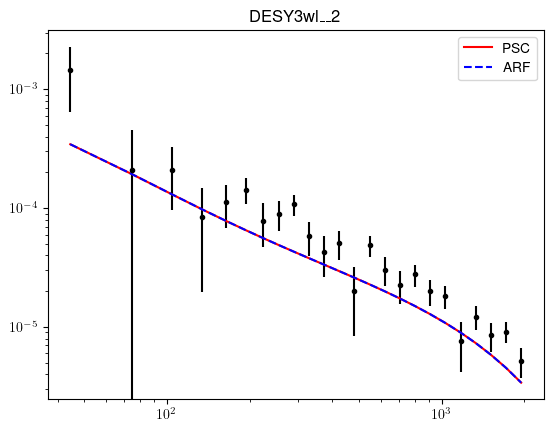

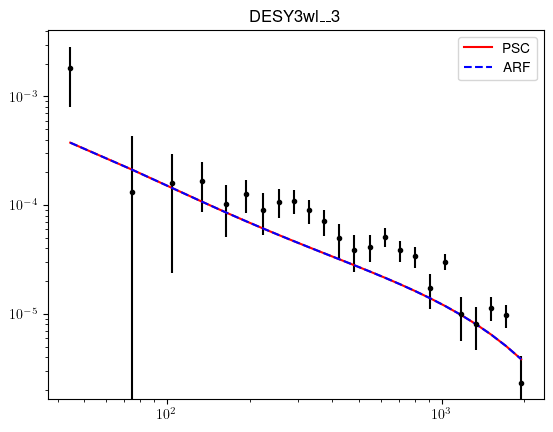

In [3]:
lc = rx.ROSATxLike(params_vary=['logTAGN'],
                   priors={'logTAGN': [7.5, 8.2]})
lcpa = rx.ROSATxLike(params_vary=['logTAGN'],
                     priors={'logTAGN': [7.5, 8.2]}, spec_pyatomdb=True)
cls_c = lc.get_model(logTAGN=8.0)
cls_pa = lcpa.get_model(logTAGN=8.0)

for i, d in enumerate(lc.cl_meta):
    plt.figure()
    plt.title(d['t2'])
    plt.errorbar(d['ls'], d['cld'],
                 yerr=np.sqrt(np.diag(d['cov'])),
                 fmt='k.')
    plt.plot(d['ls'], cls_c[i], '-', c='r', label='PSC')
    plt.plot(d['ls'], cls_pa[i], '--', c='b', label='ARF')
    plt.loglog()
    plt.legend()

data/Jtot_Z0.30_padb.pck
703.5289258994359
[6875.070218914125, 3379.5091454292024, 1495.2525068711132, 559.5910308606676, 96.92128112361245, 164.0942822931655, 341.0828342564306, 486.4512513513329]
96


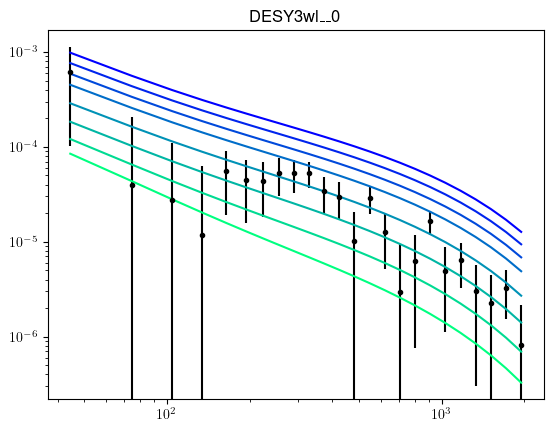

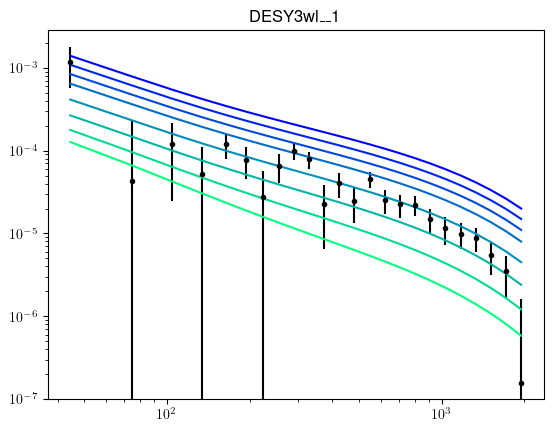

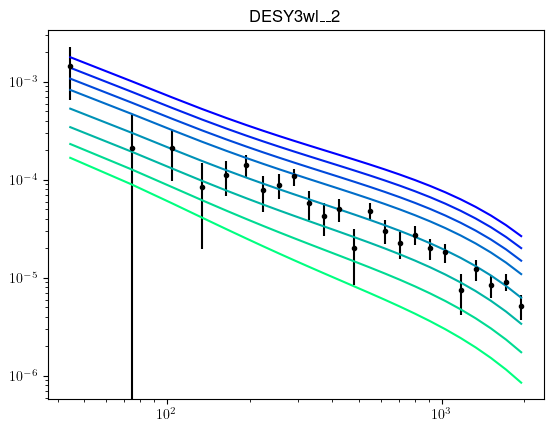

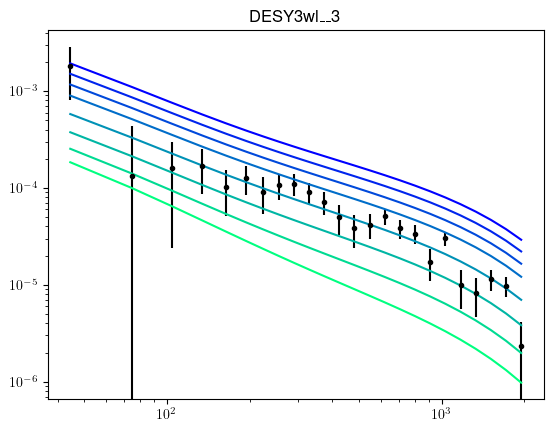

In [4]:
l = rx.ROSATxLike(params_vary=['logTAGN'],
                  priors={'logTAGN': [7.5, 8.2]},
                  spec_pyatomdb=True)

chi20 = np.dot(l.data, np.dot(l.inv_cov, l.data))
print(chi20)

pars = [{'logTAGN': 7.5},
        {'logTAGN': 7.6},
        {'logTAGN': 7.7},
        {'logTAGN': 7.8},
        {'logTAGN': 7.9},
        {'logTAGN': 8.0},
        {'logTAGN': 8.1},
        {'logTAGN': 8.2}]
clms = [l.get_model(**p) for p in pars]
chi2s = [-2*l.get_logp(**p) for p in pars]
print(chi2s)
print(l.ndata)


npar = len(pars)
color = plt.cm.winter(np.linspace(0, 1, npar))
for i, d in enumerate(l.cl_meta):
    plt.figure()
    plt.title(d['t2'])
    plt.errorbar(d['ls'], d['cld'],
                 yerr=np.sqrt(np.diag(d['cov'])),
                 fmt='k.')
    for j in range(npar):
        plt.plot(d['ls'], clms[j][i], '-', c=color[j])
    plt.loglog()


In [5]:
print("S/N = ", np.sqrt(chi20-np.amin(np.array(chi2s))))

S/N =  24.629406098723198


In [6]:
logTAGNs = np.linspace(7.84, 8.1, 128)
lMcs, gammas, alpha_Ts, logTw0s, Tw1s = np.array([l.prof_dens.from_logTAGN(lt) for lt in logTAGNs]).T
chi2s = np.array([-2*l.logp([lT], per_bin=True) for lT in logTAGNs])

In [7]:
chi2s.shape

(128, 5)

In [8]:
print(np.amin(chi2s[:, -1]), logTAGNs[np.argmin(chi2s[:, -1])])
# 83.33772026735124 8.001176470588236

87.19856914430063 7.921889763779527


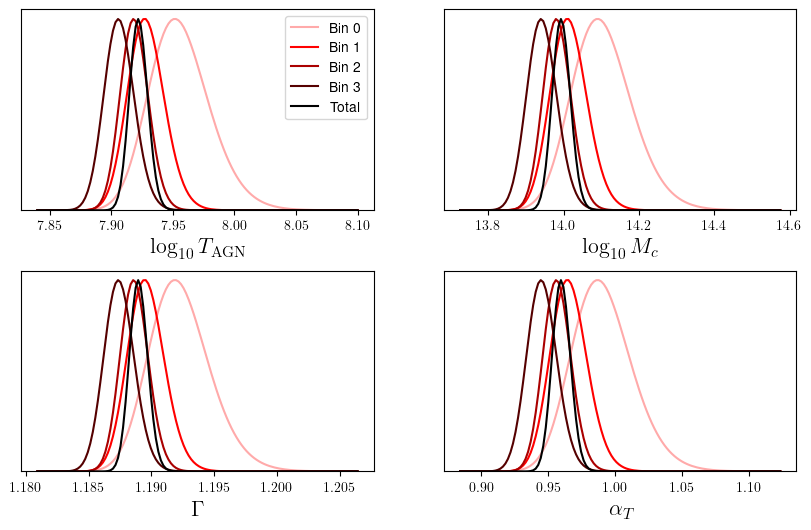

In [9]:
fig, axes = plt.subplots(2, 2,
                         figsize=(10, 6),
                         sharex=False,
                         sharey=True)
plt.subplots_adjust(hspace=0.3)
probs = np.exp(-0.5*(chi2s-np.amin(chi2s, axis=0)[None, :]))
axes = axes.flatten()
cols = ['#FFAAAA', '#FF0000', '#AA0000', '#550000', '#000000']
labels = [f'Bin {i}' for i in range(4)] + ['Total']
for p, c, lab in zip(probs.T, cols, labels):
    axes[0].plot(logTAGNs, p, '-', c=c, label=lab)
    axes[0].set_xlabel(r'$\log_{10}T_{\rm AGN}$', fontsize=16)
    axes[1].plot(lMcs, p, '-', c=c, label=lab)
    axes[1].set_xlabel(r'$\log_{10}M_c$', fontsize=16)
    axes[2].plot(gammas, p, '-', c=c, label=lab)
    axes[2].set_xlabel(r'$\Gamma$', fontsize=16)
    axes[3].plot(alpha_Ts, p, '-', c=c, label=lab)
    axes[3].set_xlabel(r'$\alpha_T$', fontsize=16)
axes[0].legend()
for ax in axes:
    ax.set_ylim([0, 1.05])
    ax.set_yticks([])

In [10]:
np.savez('constraints_1d.npz', logTAGN=logTAGNs, lMc=lMcs, alpha_T=alpha_Ts, gamma=gammas, chi2=chi2s)